# Scatter Plots

## Load Libraries

In [10]:
from obspy import UTCDateTime
from scipy.signal import welch
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from andbro__store_as_pickle import __store_as_pickle

In [11]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [12]:
## ---------------------------------------

name0 = "FFBI"

name1 = "ROMY_U"
name2 = "ROMY_V"
name3 = "ROMY_Z"


# t1 ,t2 = "2023-09-23", "2023-10-23"

In [13]:
# ## ---------------------------------------

config = {}

## specify paths
config['path_to_figs'] = data_path+f"LNM2/figures/scatter/"

config['path_to_data'] = data_path+f"LNM2/data/"

config['path_to_data'] = data_path+f"LNM2/data/"

## Methods

In [14]:
dat1 = pd.read_pickle(config['path_to_data']+name0+".pkl")
dat2 = pd.read_pickle(config['path_to_data']+name2+".pkl")

In [15]:
def __get_octave_bands(fmin, fmax, fband_type="octave", plot=False):

    """
    Computing octave / one-third-octave bands

    Arguments:
        - fmin:    (float) minimum center frequency
        - fmax:    (float) maximum center frequency
        - fband_type:    [octave] / one-third-octave
        - plot:    (bool) show frequency bands

    Example:

    >>> flower, fupper, fcenter = __get_octave_bands(f_min, f_max, fband_type="octave", plot=False)

    """

    import matplotlib.pyplot as plt
    from numpy import sqrt, array
    from acoustics import bands

    f_lower, f_upper, f_centers = [], [], []

    if fband_type == "octave":
        f_centers = bands.octave(fmin, fmax)
        f_lower = bands.octave_low(fmin, fmax)
        f_upper = bands.octave_high(fmin, fmax)

    if fband_type == "one-third-octave":
        f_centers = bands.third(fmin, fmax)
        f_lower = bands.third_low(fmin, fmax)
        f_upper = bands.third_high(fmin, fmax)

    if plot:
        plt.figure()
        for fl, fc, fu in zip(f_lower, f_centers, f_upper):
            plt.axvline(fu, color="r")
            plt.axvline(fl, color="r")
            plt.axvline(fc)
            plt.axvline(fmin, color="g")
            plt.axvline(fmax, color="g")
            plt.xscale("log")
        plt.show()

    return array(f_lower), array(f_upper), array(f_centers)

In [16]:
def __quantile_regression(x, y, quantiles=[0.05, 0.5, 0.95]):


    from sklearn.utils.fixes import parse_version, sp_version
    from sklearn.linear_model import QuantileRegressor
    from numpy import newaxis, zeros_like, bool_, logical_or, array

    # This is line is to avoid incompatibility if older SciPy version.
    # You should use `solver="highs"` with recent version of SciPy.
    solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

    predictions = {}

    x = array(x)
    X = x[:, newaxis]

    out_bounds_predictions = zeros_like(y, dtype=bool_)

    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = y_pred

        if quantile == min(quantiles):
            out_bounds_predictions = logical_or(
                out_bounds_predictions, y_pred >= y
            )
        elif quantile == max(quantiles):
            out_bounds_predictions = logical_or(
                out_bounds_predictions, y_pred <= y
            )

    print(qr.score(X, y))
    return predictions

In [17]:
f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, fband_type="one-third-octave", plot=False)

N_bands = dat1.shape[1] - 1

bands = dat1.keys()[1:]

for _n, band in enumerate(bands):

    if not _n == 10:
        continue

    _dat1 = dat1.loc[:, ["dates", band]]
    _dat2 = dat2.loc[:, ["dates", band]]

    _df = pd.merge(left=_dat1, right=_dat2, how="inner", on="dates")

    _df.dropna(inplace=True)

    _df = _df[_df.iloc[:, 1] < 1e-15]
    _df = _df.reset_index(drop=True)


    xx = np.log10(_df.iloc[:, 1])
    yy = np.log10(_df.iloc[:, 2])

    try:
        pre = __quantile_regression(xx, yy, quantiles=[0.1, 0.5, 0.9])

    except:
        continue

    if not _df.empty:

        fig = plt.figure()

        # ys = powerfit(xx, pre, xx)
        # plt.plot(xx, ys, color="tab:green", ls="--")

        # plt.scatter(_df[f'{band}_x'], _df[f'{band}_y'], s=15, edgecolors="black", lw=0.5, zorder=2)
        plt.scatter(10**xx, 10**yy, s=15, edgecolors="black", lw=0.5, zorder=2)

        plt.plot(10**xx, 10**pre[0.9], color="k", zorder=1, ls=":")

        plt.xscale("log")
        plt.yscale("log")

        plt.title(f"{name1.replace('_','-')} & {name2.replace('_','-')} | fc = {float(_df.keys()[1][:-2])*1e3} mHz")
        plt.ylabel(r"PSD (hPa$^2$ /Hz)")
        plt.xlabel(r"PSD (rad$^2$ /s$^2$ /Hz)")
        plt.grid(zorder=0, alpha=0.5)

        plt.ylim(1e-7, 1e1)
        plt.xlim(1e-23, 1e-15)

        plt.show();

        fig.savefig(config['path_to_figs']+f"{name1}/{str(_n).rjust(3, '0')}_{name1}_{name2}_{band}Hz.png", format="png", dpi=200, bbox_inches='tight');

## Plot all 

In [18]:
dat0 = pd.read_pickle(config['path_to_data']+name0+".pkl")

dat1 = pd.read_pickle(config['path_to_data']+name1+".pkl")
dat2 = pd.read_pickle(config['path_to_data']+name2+".pkl")
dat3 = pd.read_pickle(config['path_to_data']+name3+".pkl")


coh1 = pd.read_pickle(config['path_to_data']+name1+"_coherence.pkl")
coh2 = pd.read_pickle(config['path_to_data']+name2+"_coherence.pkl")
coh3 = pd.read_pickle(config['path_to_data']+name3+"_coherence.pkl")


In [19]:
coh1

dates     0.001  0.00125    0.0016     0.002    0.0025   0.00315  \
0    20230923_00  0.884820      NaN  0.586088  0.886626  0.870930  0.864408   
1    20230923_01  0.611224      NaN  0.772154  0.950437  0.917110  0.598060   
2    20230923_02  0.787101      NaN  0.712703  0.799313  0.464563  0.176025   
3    20230923_03  0.486220      NaN  0.810146  0.370693  0.276784  0.464697   
4    20230923_04  0.602541      NaN  0.809993  0.595930  0.051593  0.473190   
..           ...       ...      ...       ...       ...       ...       ...   
715  20231022_19  0.715237      NaN  0.378734  0.671944  0.395044  0.414272   
716  20231022_20  0.733486      NaN  0.837404  0.291052  0.288056  0.495139   
717  20231022_21  0.843480      NaN  0.731049  0.558032  0.826667  0.126771   
718  20231022_22  0.713166      NaN  0.812352  0.957705  0.798966  0.303530   
719  20231022_23  0.766745      NaN  0.702128  0.884135  0.566548  0.693034   

        0.004     0.005    0.0063  ...     0.125      0.16       0.2  \
0    0.225368  0.271236  0.540983  ...  0.379287  0.295743  0.357775   
1    0.515071  0.338357  0.509612  ...  0.400834  0.262321  0.331414   
2    0.356715  0.163409  0.156375  ...  0.348857  0.368961  0.324251   
3    0.337879  0.606809  0.556047  ...  0.332307  0.355249  0.320473   
4    0.606414  0.537577  0.492203  ...  0.303300  0.358782  0.415788   
..        ...       ...       ...  ...       ...       ...       ...   
715  0.036274  0.581679  0.420100  ...  0.336299  0.318737  0.312435   
716  0.260402  0.456266  0.209297  ...  0.298150  0.332767  0.300494   
717  0.456192  0.657703  0.470357  ...  0.318679  0.343202  0.335184   
718  0.647036  0.457111  0.121578  ...  0.400534  0.274772  0.311048   
719  0.148666  0.540472  0.592620  ...  0.328462  0.357791  0.346965   

         0.25     0.315       0.4       0.5      0.63       0.8       1.0  
0    0.373598  0.319956  0.331023  0.322846  0.331670  0.325933  0.315645  
1    0.253905  0.294845  0.316142  0.349407  0.365851  0.366246  0.335143  
2    0.304461  0.352143  0.291368  0.345958  0.360255  0.342395  0.340200  
3    0.392110  0.319454  0.360255  0.349032  0.364221  0.341569  0.339956  
4    0.376255  0.401746  0.344176  0.380038  0.368383  0.348951  0.343756  
..        ...       ...       ...       ...       ...       ...       ...  
715  0.336560  0.352112  0.325046  0.334589  0.335760  0.334268  0.323648  
716  0.302299  0.305550  0.350130  0.308874  0.364947  0.347297  0.329823  
717  0.377434  0.362617  0.331934  0.327296  0.332432  0.367695  0.350723  
718  0.345818  0.343117  0.384035  0.351707  0.335393  0.369335  0.342594  
719  0.356678  0.338031  0.345199  0.358240  0.326830  0.359795  0.358053  

[720 rows x 32 columns]

-1.6194966277632683
-1.6204107926354734
-4.756331027272176


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 0.9 - 1.1 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 0.9 - 1.1 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 0.9 - 1.1 mHz')

Text(0.01, 0.04, 'N=234')

Text(0.01, 0.04, 'N=278')

Text(0.01, 0.04, 'N=719')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

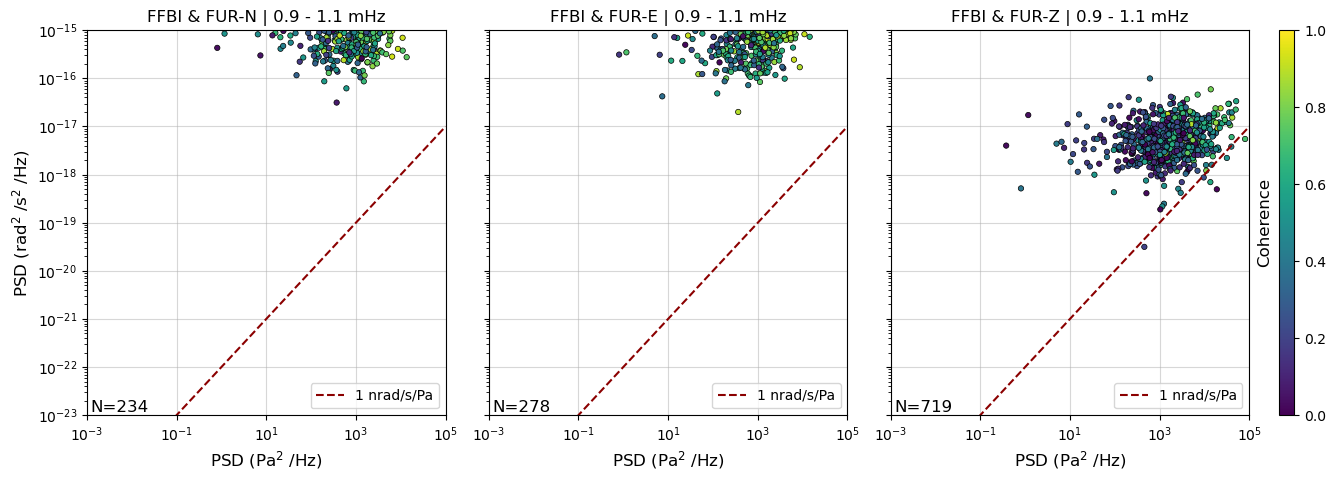

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by QuantileRegressor.


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 1.1 - 1.4 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 1.1 - 1.4 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 1.1 - 1.4 mHz')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=0')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

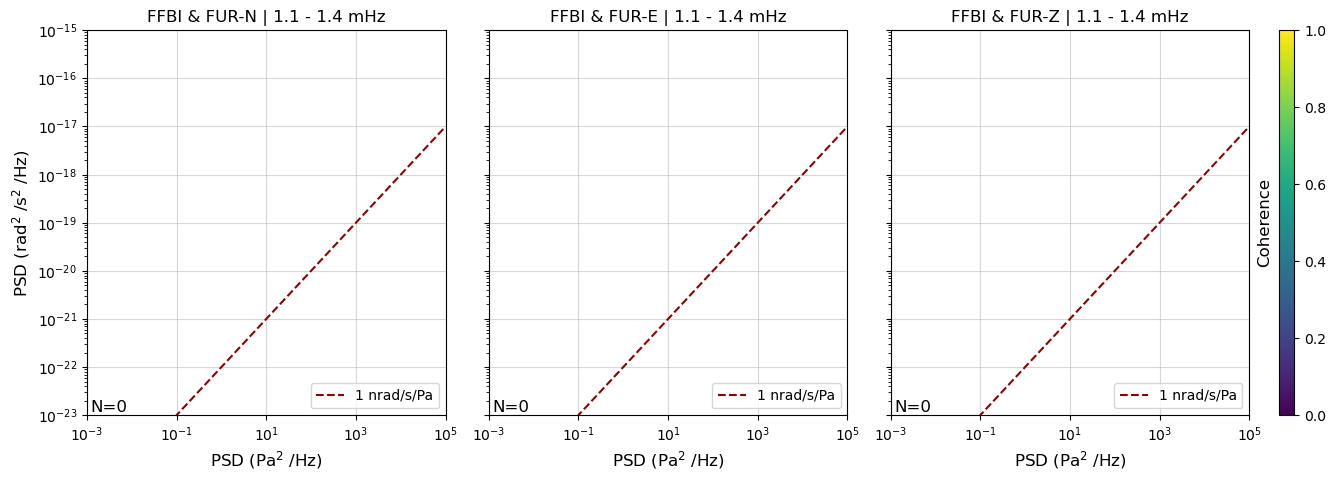

-1.7260601386505465
-1.7468754113322968
-4.2931641376383585


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 1.4 - 1.8 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 1.4 - 1.8 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 1.4 - 1.8 mHz')

Text(0.01, 0.04, 'N=313')

Text(0.01, 0.04, 'N=355')

Text(0.01, 0.04, 'N=720')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

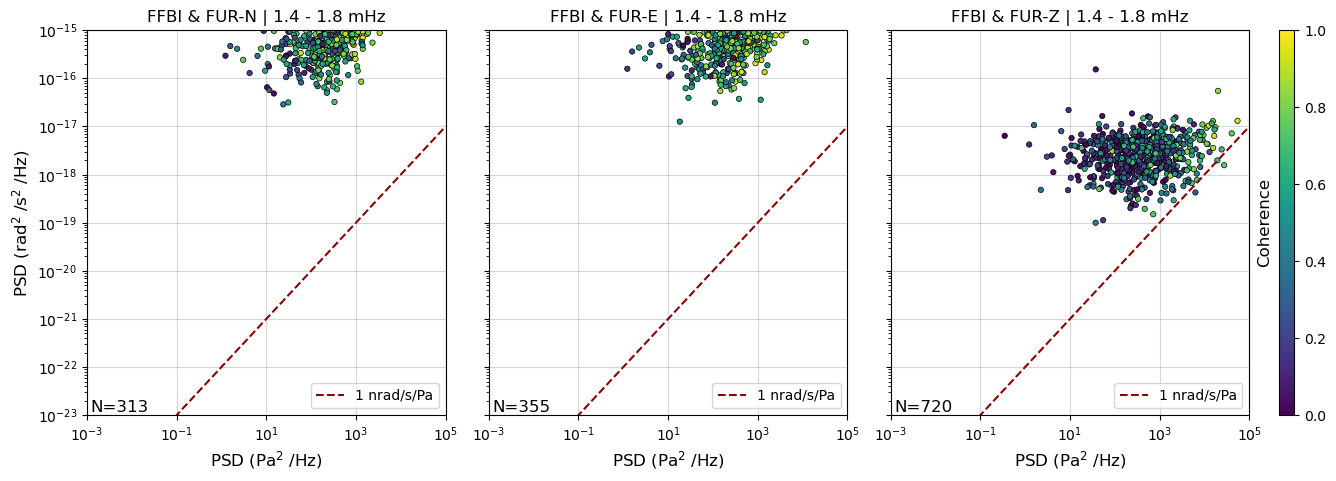

-1.8329804529704687
-2.1299168916575772
-7.139360745919797


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 1.8 - 2.2 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 1.8 - 2.2 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 1.8 - 2.2 mHz')

Text(0.01, 0.04, 'N=417')

Text(0.01, 0.04, 'N=447')

Text(0.01, 0.04, 'N=720')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

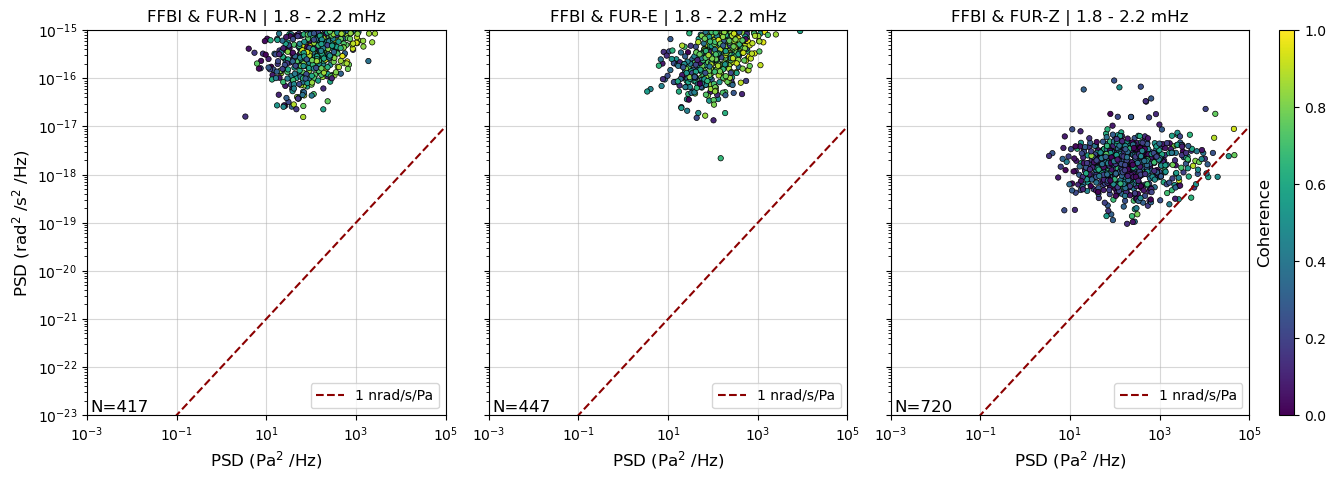

-2.2308304381291784
-2.06852968909434
-11.175241678681848


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 2.2 - 2.8 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 2.2 - 2.8 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 2.2 - 2.8 mHz')

Text(0.01, 0.04, 'N=508')

Text(0.01, 0.04, 'N=543')

Text(0.01, 0.04, 'N=720')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

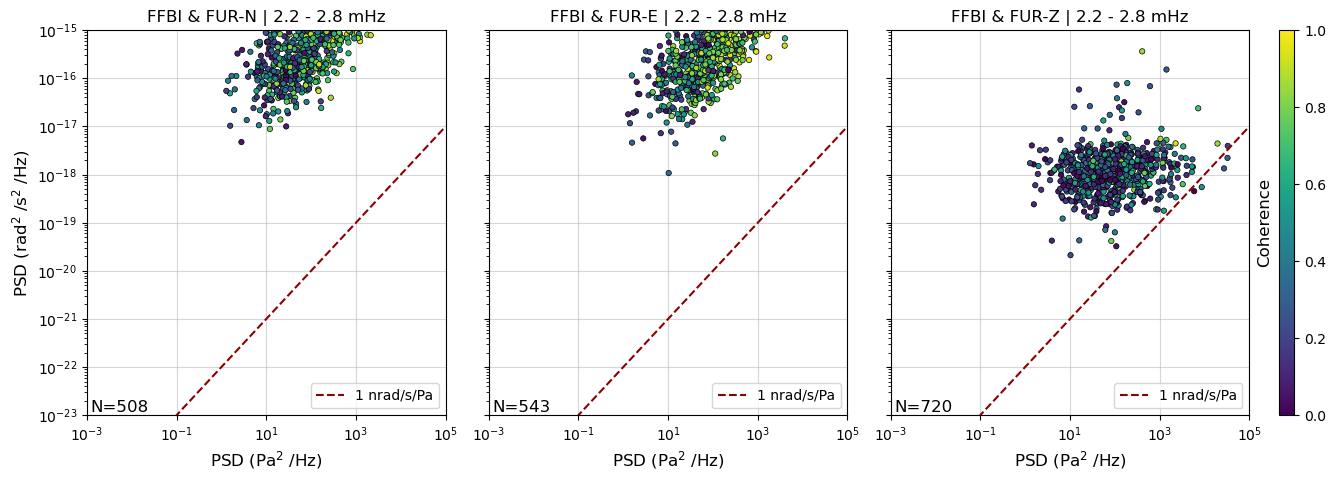

-2.4319666699801705
-2.396898826014134
-11.564554428008508


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 2.8 - 3.5 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 2.8 - 3.5 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 2.8 - 3.5 mHz')

Text(0.01, 0.04, 'N=555')

Text(0.01, 0.04, 'N=581')

Text(0.01, 0.04, 'N=720')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

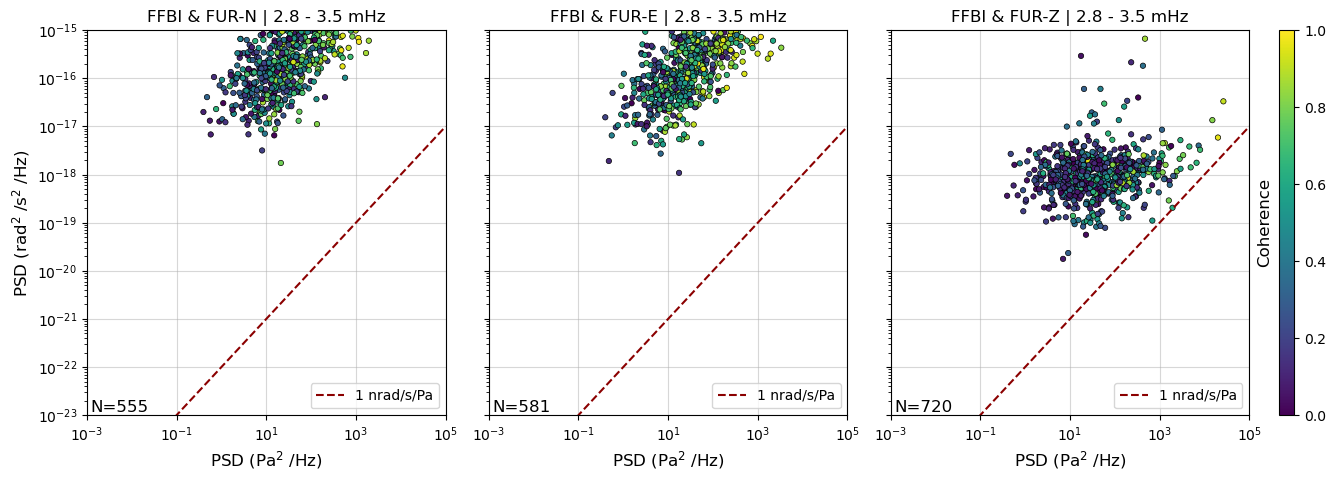

-2.0844269349100437
-2.412623949673764
-13.243972393777346


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 3.6 - 4.5 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 3.6 - 4.5 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 3.6 - 4.5 mHz')

Text(0.01, 0.04, 'N=589')

Text(0.01, 0.04, 'N=609')

Text(0.01, 0.04, 'N=720')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

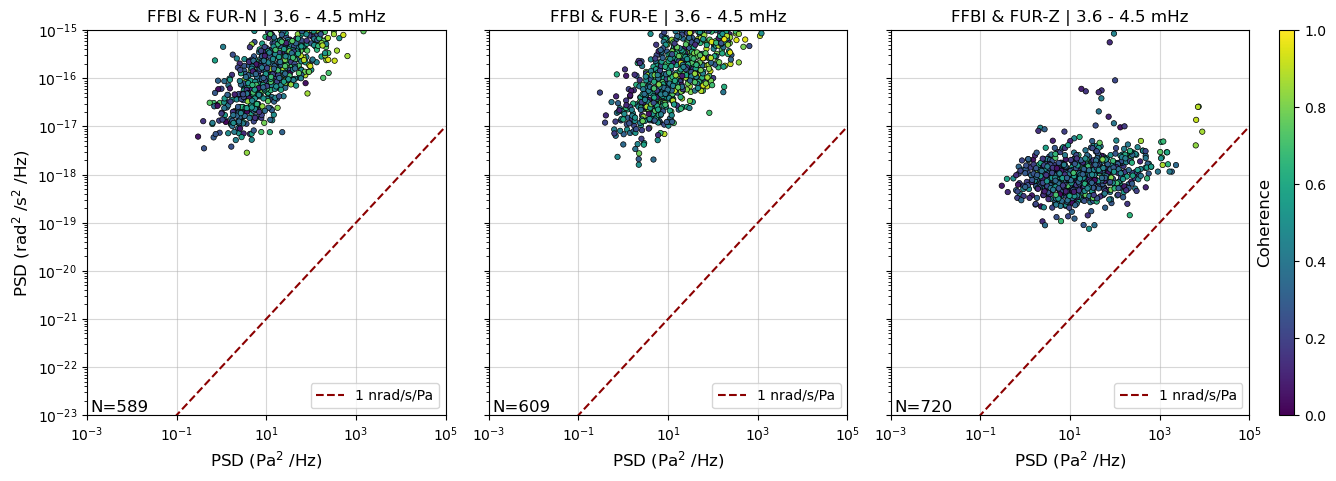

-2.2680611091015694
-1.6343118633361833
-16.053875777853378


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 4.5 - 5.6 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 4.5 - 5.6 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 4.5 - 5.6 mHz')

Text(0.01, 0.04, 'N=624')

Text(0.01, 0.04, 'N=619')

Text(0.01, 0.04, 'N=718')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

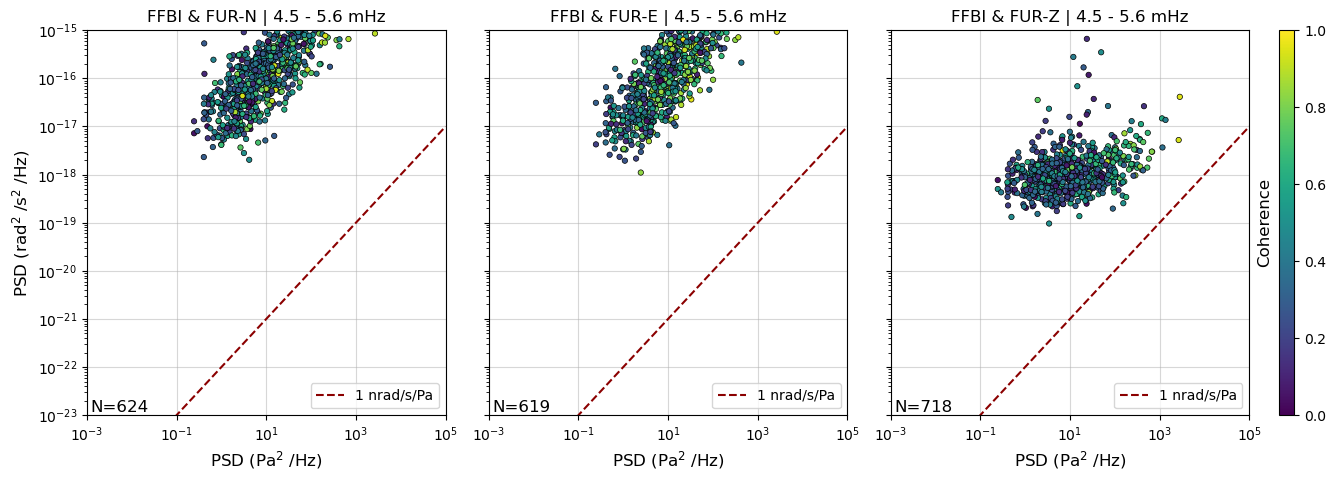

-2.2809167501633407
-1.5357503690068532
-13.02957669631948


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 5.6 - 7.1 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 5.6 - 7.1 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 5.6 - 7.1 mHz')

Text(0.01, 0.04, 'N=634')

Text(0.01, 0.04, 'N=633')

Text(0.01, 0.04, 'N=718')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

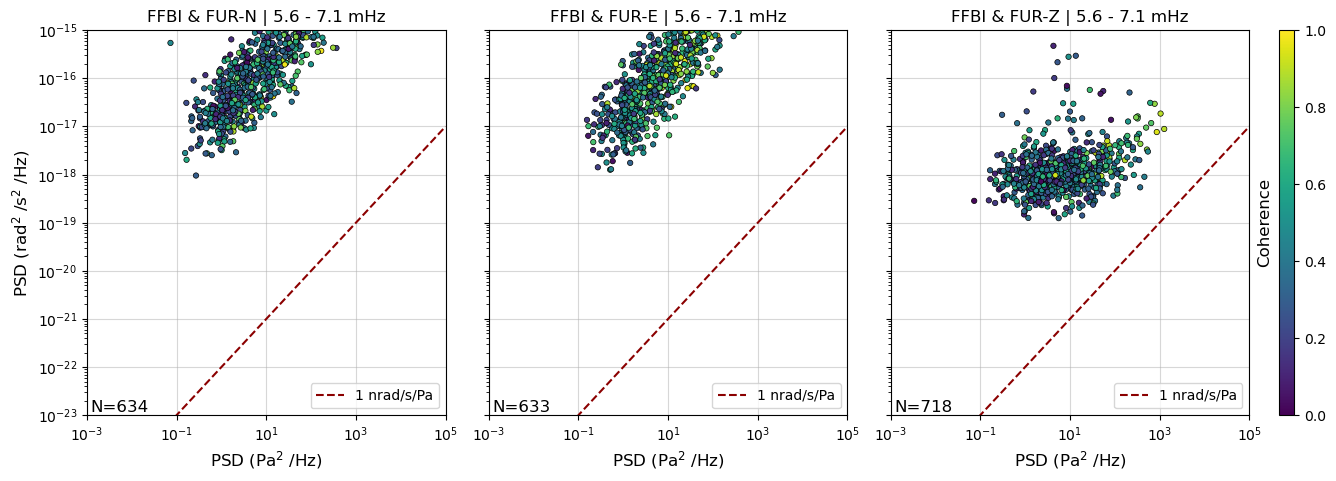

-1.7869444853491658
-0.9010587786769113
-13.49868204193057


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 7.1 - 9.0 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 7.1 - 9.0 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 7.1 - 9.0 mHz')

Text(0.01, 0.04, 'N=650')

Text(0.01, 0.04, 'N=647')

Text(0.01, 0.04, 'N=718')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

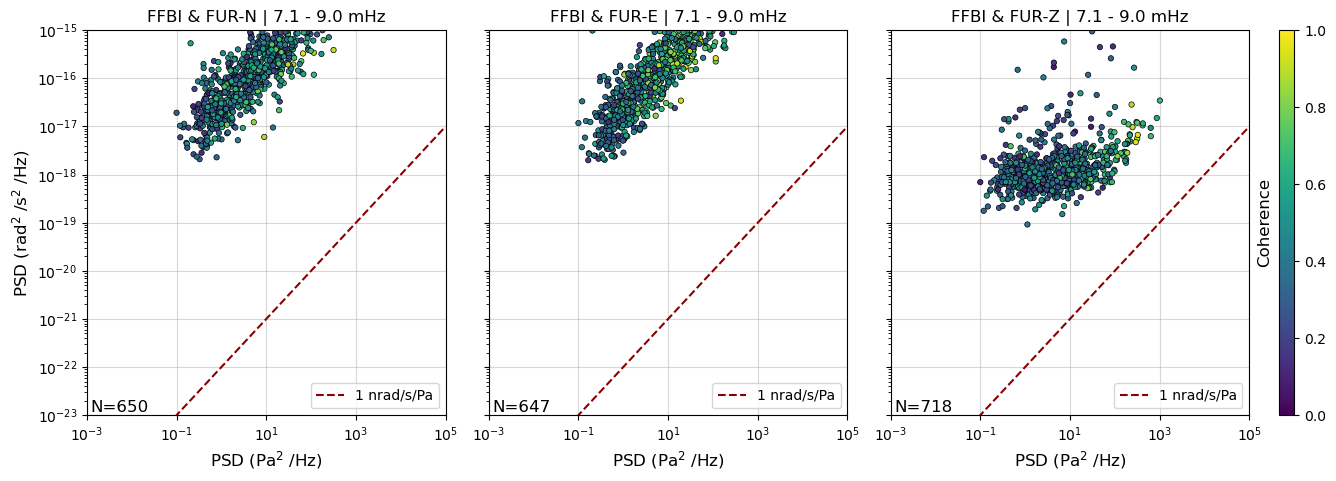

-1.520120892599512
-1.5870679164582424
-11.61483967721545


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 8.9 - 11.2 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 8.9 - 11.2 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 8.9 - 11.2 mHz')

Text(0.01, 0.04, 'N=654')

Text(0.01, 0.04, 'N=660')

Text(0.01, 0.04, 'N=717')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

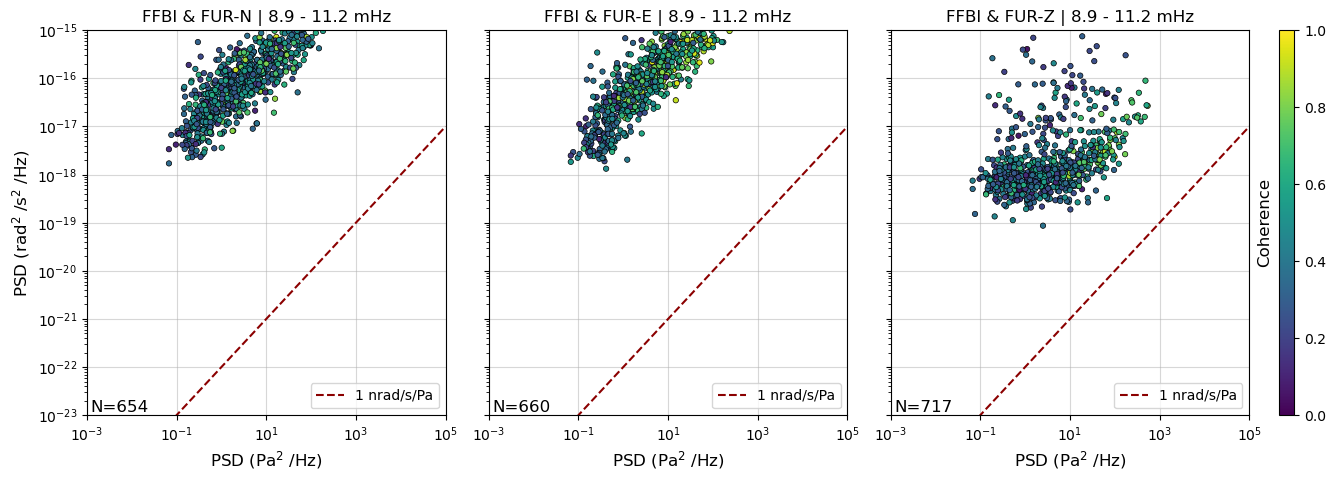

-1.8727500771664407
-2.2998890211766643
-12.610471813764043


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 11.1 - 14.0 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 11.1 - 14.0 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 11.1 - 14.0 mHz')

Text(0.01, 0.04, 'N=657')

Text(0.01, 0.04, 'N=655')

Text(0.01, 0.04, 'N=714')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

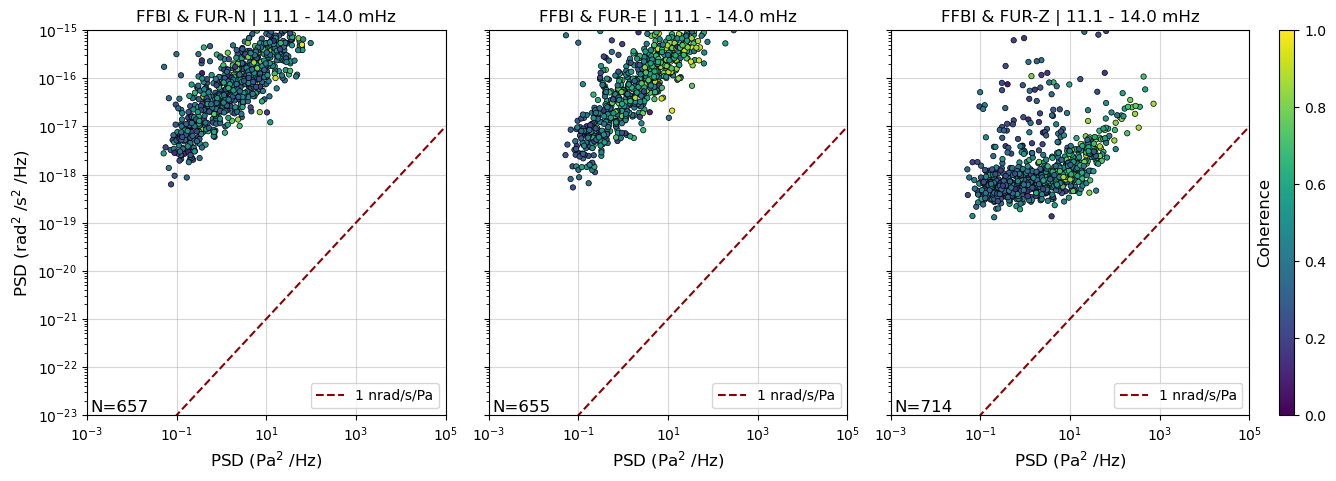

-1.722681748501358
-1.8742867697874974
-11.041279335049454


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 14.3 - 18.0 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 14.3 - 18.0 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 14.3 - 18.0 mHz')

Text(0.01, 0.04, 'N=661')

Text(0.01, 0.04, 'N=657')

Text(0.01, 0.04, 'N=712')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

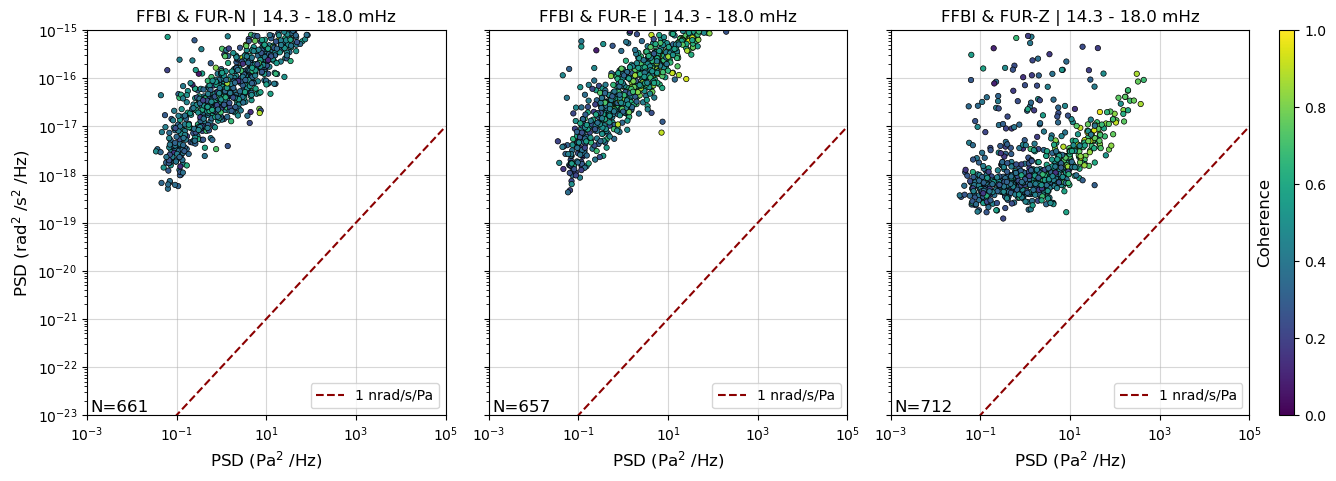

-2.333901754680902
-2.1795462253676905
-10.591159374988301


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 17.8 - 22.4 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 17.8 - 22.4 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 17.8 - 22.4 mHz')

Text(0.01, 0.04, 'N=667')

Text(0.01, 0.04, 'N=657')

Text(0.01, 0.04, 'N=705')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

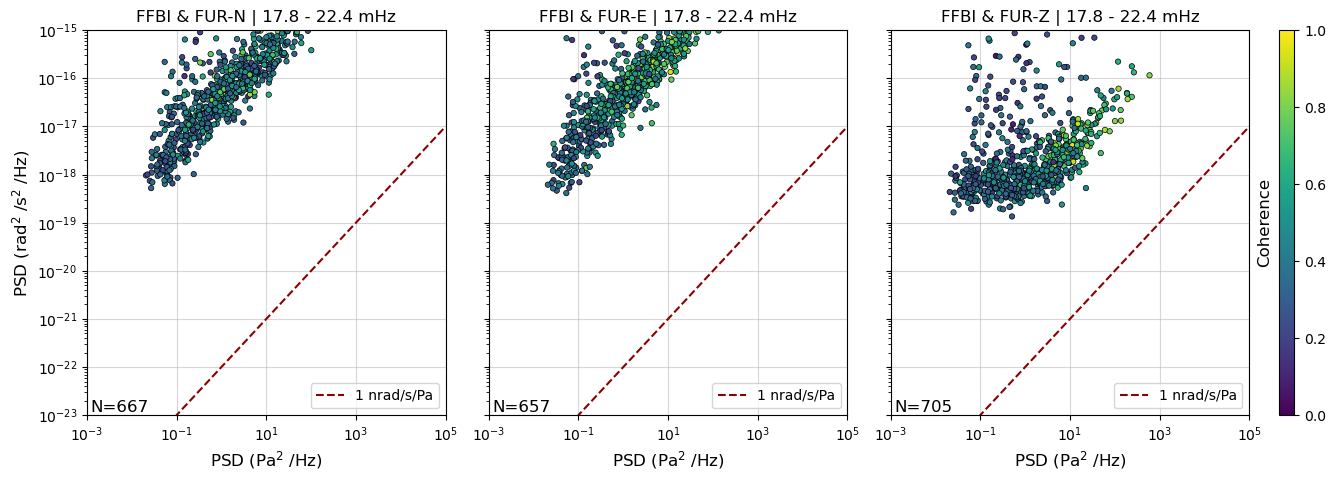

-3.0452771525089206
-2.4031860878851137
-9.494988488165996


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 22.3 - 28.1 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 22.3 - 28.1 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 22.3 - 28.1 mHz')

Text(0.01, 0.04, 'N=661')

Text(0.01, 0.04, 'N=653')

Text(0.01, 0.04, 'N=696')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

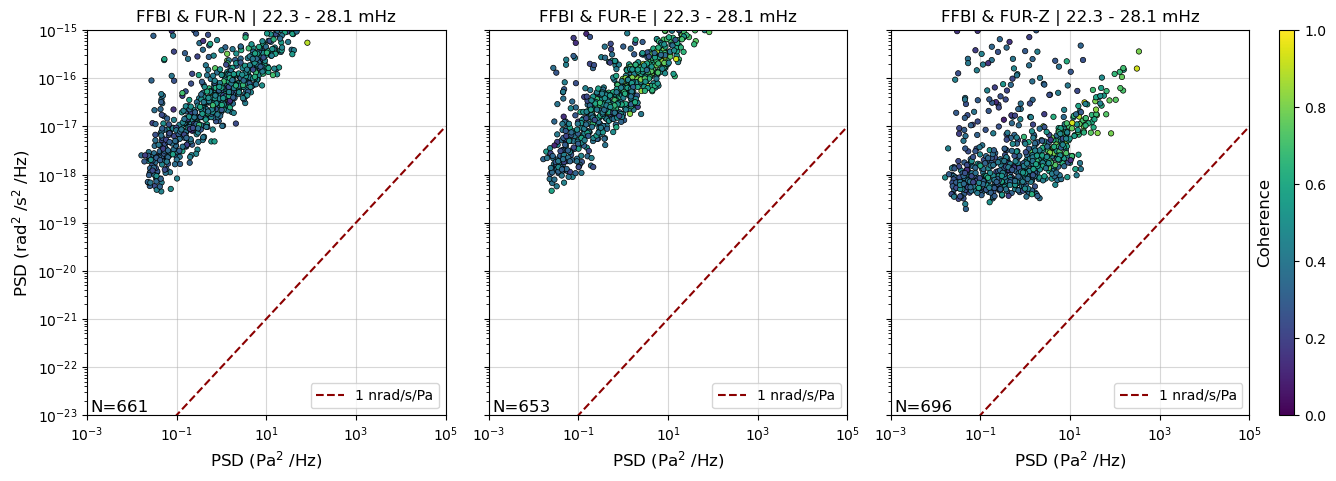

-3.0785749599366383
-3.282420607405908
-8.184943950796521


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 28.1 - 35.4 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 28.1 - 35.4 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 28.1 - 35.4 mHz')

Text(0.01, 0.04, 'N=649')

Text(0.01, 0.04, 'N=642')

Text(0.01, 0.04, 'N=679')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

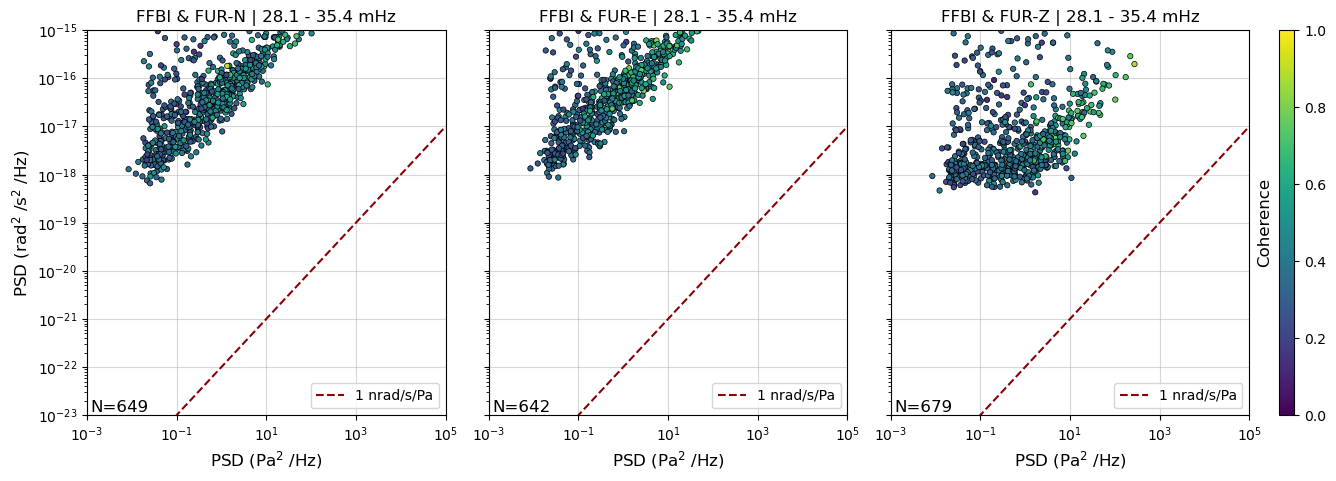

-3.8233048874375886
-3.6601863353322575
-6.912033149968823


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 35.6 - 44.9 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 35.6 - 44.9 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 35.6 - 44.9 mHz')

Text(0.01, 0.04, 'N=646')

Text(0.01, 0.04, 'N=638')

Text(0.01, 0.04, 'N=659')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

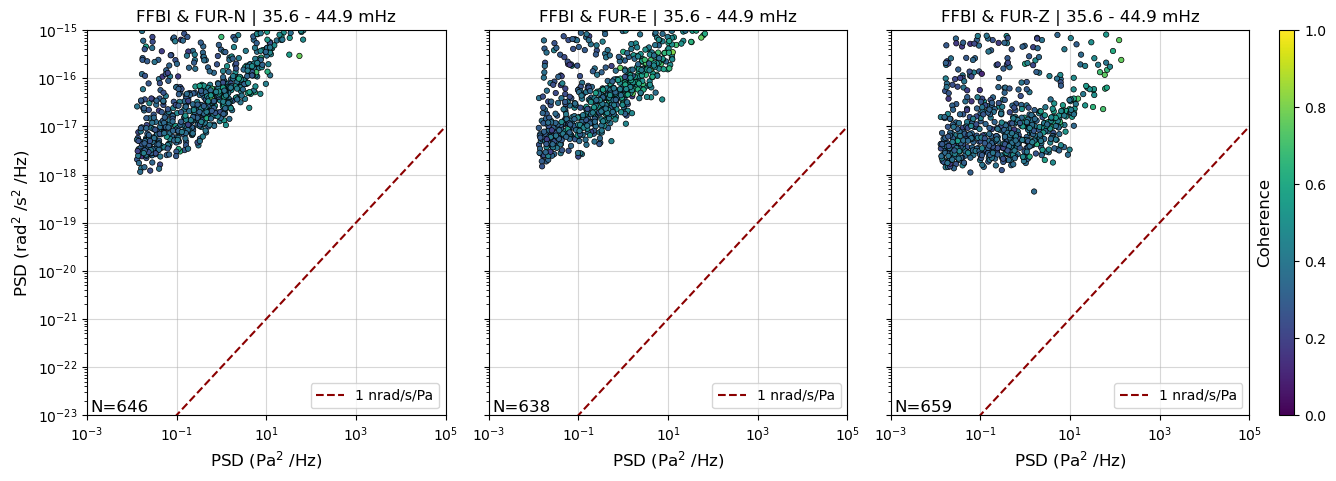

-5.38986051543773
-4.189804302699871
-6.766306988963843


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 44.5 - 56.1 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 44.5 - 56.1 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 44.5 - 56.1 mHz')

Text(0.01, 0.04, 'N=627')

Text(0.01, 0.04, 'N=618')

Text(0.01, 0.04, 'N=628')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

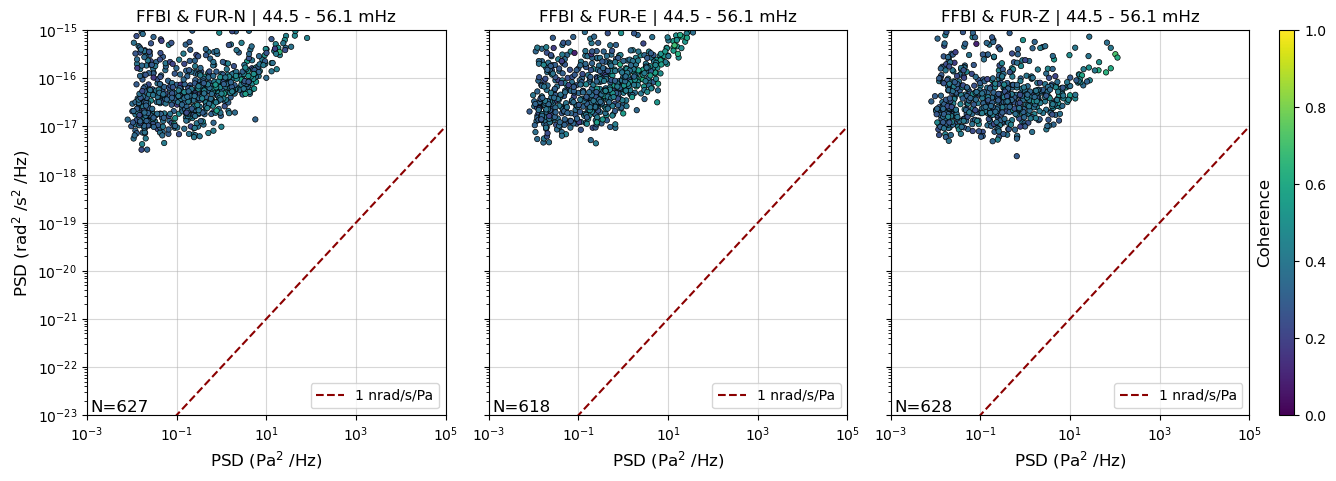

-3.218866299258763
-3.0314702152308444
-3.6012366387559798


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 56.1 - 70.7 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 56.1 - 70.7 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 56.1 - 70.7 mHz')

Text(0.01, 0.04, 'N=579')

Text(0.01, 0.04, 'N=552')

Text(0.01, 0.04, 'N=618')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

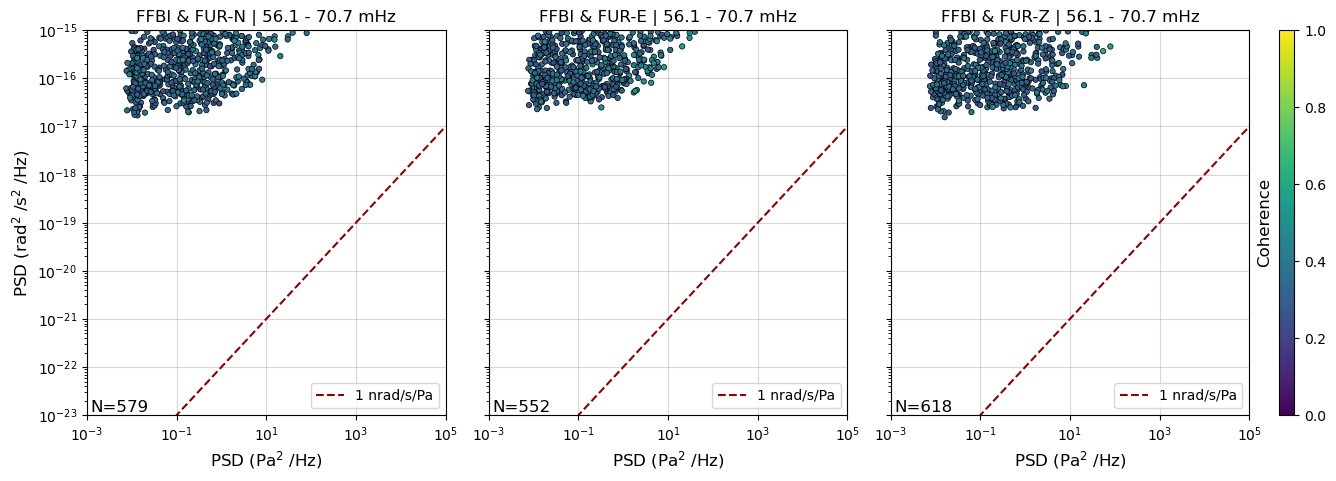

-2.6459584023850784
-2.541858158731219
-3.142359776470082


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 71.3 - 89.8 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 71.3 - 89.8 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 71.3 - 89.8 mHz')

Text(0.01, 0.04, 'N=540')

Text(0.01, 0.04, 'N=529')

Text(0.01, 0.04, 'N=591')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

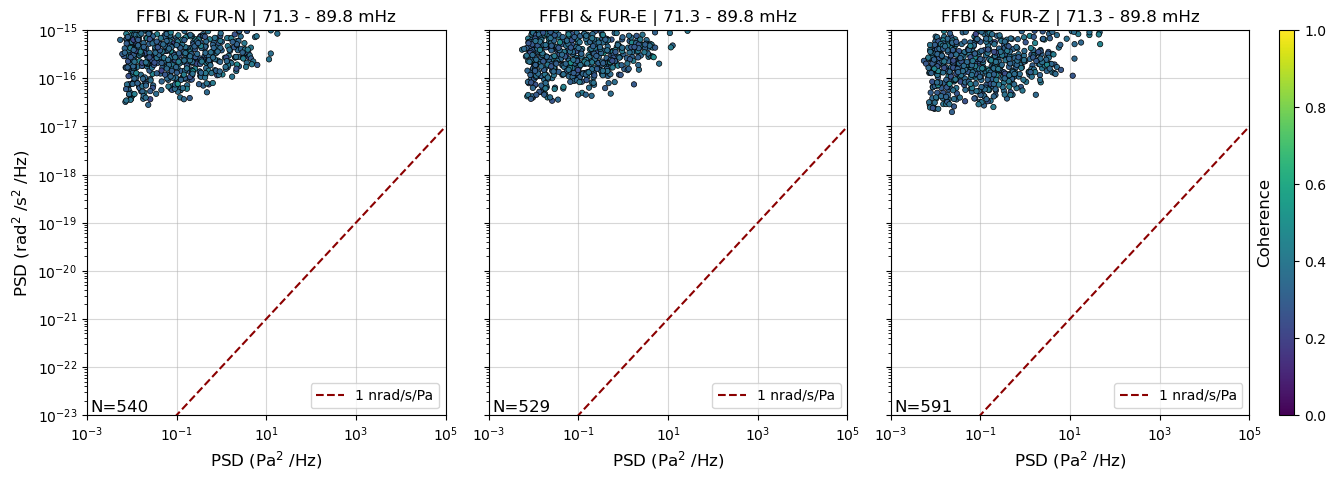

-4.511719172403956
-3.9994036399244255
-5.236696517206776


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 89.1 - 112.2 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 89.1 - 112.2 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 89.1 - 112.2 mHz')

Text(0.01, 0.04, 'N=604')

Text(0.01, 0.04, 'N=566')

Text(0.01, 0.04, 'N=639')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

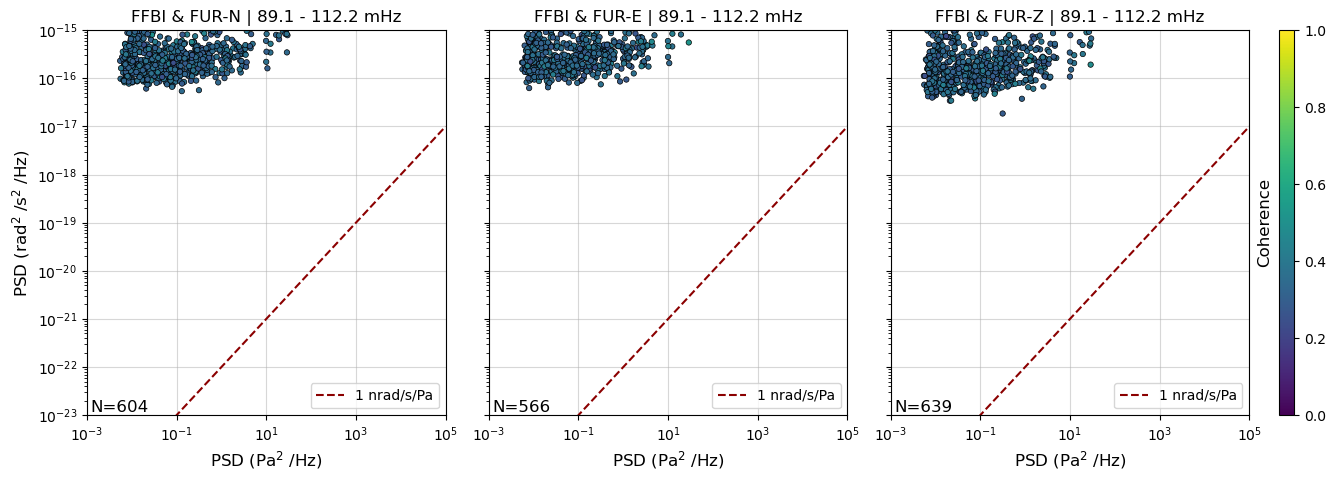

-3.4939308886519767
-3.1405127577732497
-3.06039609690895


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 111.4 - 140.3 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 111.4 - 140.3 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 111.4 - 140.3 mHz')

Text(0.01, 0.04, 'N=182')

Text(0.01, 0.04, 'N=176')

Text(0.01, 0.04, 'N=242')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

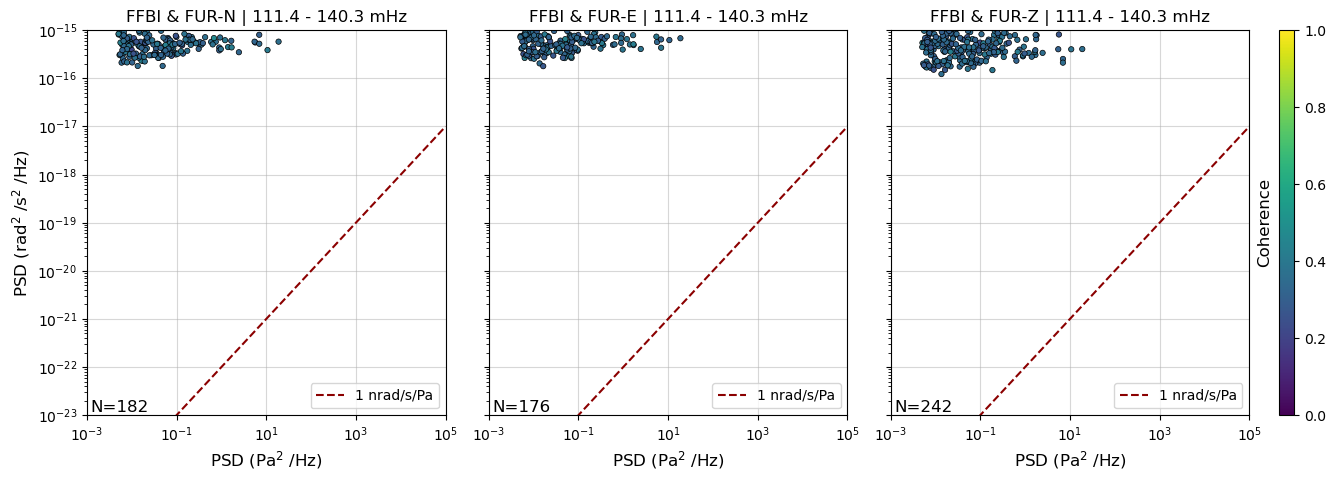

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by QuantileRegressor.


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 142.5 - 179.6 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 142.5 - 179.6 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 142.5 - 179.6 mHz')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=11')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

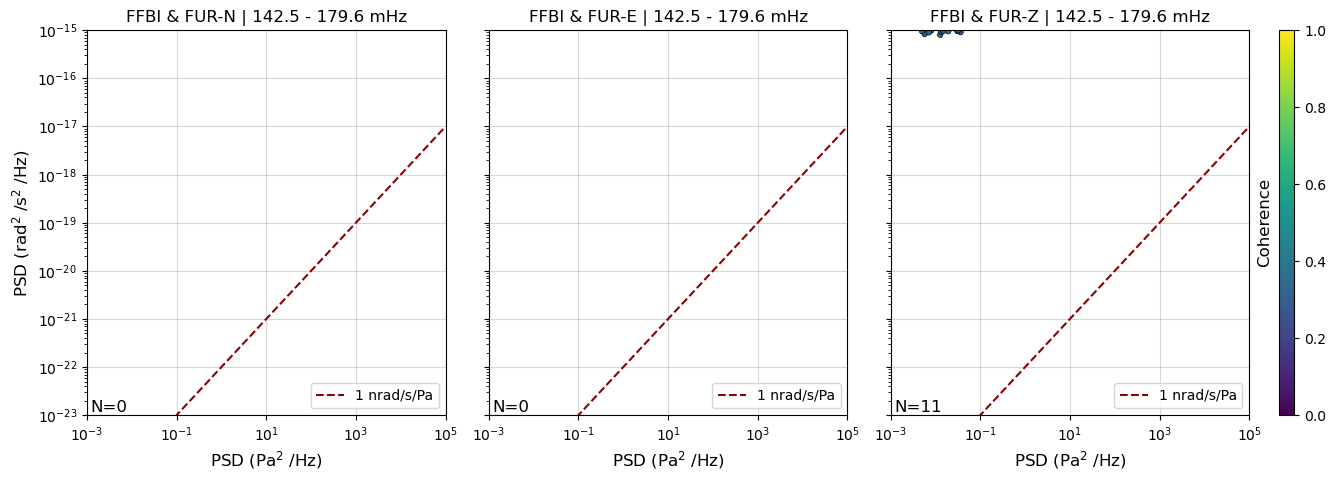

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by QuantileRegressor.


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 178.2 - 224.5 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 178.2 - 224.5 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 178.2 - 224.5 mHz')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=0')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

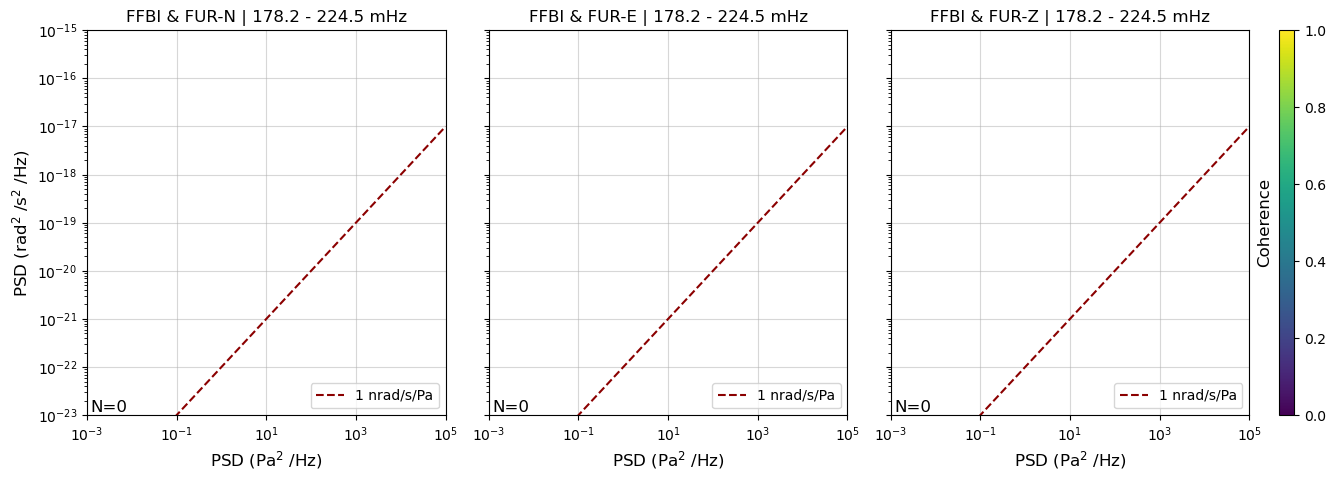

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by QuantileRegressor.


(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & FUR-N | 222.7 - 280.6 mHz')

Text(0.5, 1.0, 'FFBI & FUR-E | 222.7 - 280.6 mHz')

Text(0.5, 1.0, 'FFBI & FUR-Z | 222.7 - 280.6 mHz')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=1')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

KeyboardInterrupt: 

In [20]:
f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, fband_type="one-third-octave", plot=False)

N_bands = dat0.shape[1] - 1

bands = dat0.keys()[1:]

for _n, band in enumerate(bands):

#     if not _n == 13:
#         continue

    _dat0 = dat0.loc[:, ["dates", band]]
    _dat1 = dat1.loc[:, ["dates", band]]
    _dat2 = dat2.loc[:, ["dates", band]]
    _dat3 = dat3.loc[:, ["dates", band]]

    _coh1 = coh1.loc[:, ["dates", band]]
    _coh2 = coh2.loc[:, ["dates", band]]
    _coh3 = coh3.loc[:, ["dates", band]]

    ## join data frames based on dates and hour
    _df1 = pd.merge(left=_dat0, right=_dat1, how="inner", on="dates")
    _df2 = pd.merge(left=_dat0, right=_dat2, how="inner", on="dates")
    _df3 = pd.merge(left=_dat0, right=_dat3, how="inner", on="dates")

    _df1 = pd.merge(left=_df1, right=_coh1, how="inner", on="dates")
    _df2 = pd.merge(left=_df2, right=_coh2, how="inner", on="dates")
    _df3 = pd.merge(left=_df3, right=_coh3, how="inner", on="dates")

    # ## remove NaN values
    _df1.dropna(inplace=True)
    _df2.dropna(inplace=True)
    _df3.dropna(inplace=True)

    ## remove large values
    _df1 = _df1[_df1.iloc[:, 2] < 1e-15]
    _df2 = _df2[_df2.iloc[:, 2] < 1e-15]
    _df3 = _df3[_df3.iloc[:, 2] < 1e-15]

    ## reset the index
    _df1 = _df1.reset_index(drop=True)
    _df2 = _df2.reset_index(drop=True)
    _df3 = _df3.reset_index(drop=True)

    xx1, yy1, ccoh1 = np.log10(_df1.iloc[:, 1]), np.log10(_df1.iloc[:, 2]), _df1.iloc[:, 3]
    xx2, yy2, ccoh2 = np.log10(_df2.iloc[:, 1]), np.log10(_df2.iloc[:, 2]), _df2.iloc[:, 3]
    xx3, yy3, ccoh3 = np.log10(_df3.iloc[:, 1]), np.log10(_df3.iloc[:, 2]), _df3.iloc[:, 3]

    try:
        pre1 = __quantile_regression(xx1, yy1, quantiles=[0.01, 0.5, 0.99])
        pre2 = __quantile_regression(xx2, yy2, quantiles=[0.01, 0.5, 0.99])
        pre3 = __quantile_regression(xx3, yy3, quantiles=[0.01, 0.5, 0.99])

    except Exception as e:
        print(e)
        pass


    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    font = 12

    cmap = plt.colormaps.get("viridis")

    plt.subplots_adjust(wspace=0.12)

    ca1 = ax[0].scatter(10**xx1, 10**yy1, s=15, c=ccoh1, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
    ca2 = ax[1].scatter(10**xx2, 10**yy2, s=15, c=ccoh2, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
    ca3 = ax[2].scatter(10**xx3, 10**yy3, s=15, c=ccoh3, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)

#     try:

#         ax[0].plot(10**xx1, 10**pre1[0.01], color="k", zorder=1, ls=":", label="90%-fit")
#         ax[1].plot(10**xx2, 10**pre2[0.01], color="k", zorder=1, ls=":", label="90%-fit")
#         ax[2].plot(10**xx3, 10**pre3[0.01], color="k", zorder=1, ls=":", label="90%-fit")

#     except Exception as e:
#         print(e)
#         pass

    ## add correlation estimate
    _xx = np.logspace(-5, 5)
    _yy = 1e-22 * _xx
    # print(_xx, _yy)

    for _i in range(3):
        ax[_i].plot(_xx, _yy, color="darkred", ls="--", label="1 nrad/s/Pa")

    for _i in range(3):
        ax[_i].set_xscale("log")
        ax[_i].set_yscale("log")
        ax[_i].set_xlim(1e-3, 1e5)
        ax[_i].set_ylim(1e-23, 1e-15)
        ax[_i].grid(zorder=0, alpha=0.5)
        ax[_i].legend(loc=4)
        ax[_i].set_xlabel(r"PSD (Pa$^2$ /Hz)", fontsize=font)

    # ax[0].set_title(f"{name0.replace('_','-')} & {name1.replace('_','-')} | fc = {float(_df1.keys()[1][:-2])*1e3} mHz")
    # ax[1].set_title(f"{name0.replace('_','-')} & {name2.replace('_','-')} | fc = {float(_df2.keys()[1][:-2])*1e3} mHz")
    # ax[2].set_title(f"{name0.replace('_','-')} & {name3.replace('_','-')} | fc = {float(_df3.keys()[1][:-2])*1e3} mHz")
    ax[0].set_title(f"{name0.replace('_','-')} & {name1.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")
    ax[1].set_title(f"{name0.replace('_','-')} & {name2.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")
    ax[2].set_title(f"{name0.replace('_','-')} & {name3.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")

    ax[0].text(.01, .04, f"N={len(xx1)}", ha='left', va='top', transform=ax[0].transAxes, fontsize=font)
    ax[1].text(.01, .04, f"N={len(xx2)}", ha='left', va='top', transform=ax[1].transAxes, fontsize=font)
    ax[2].text(.01, .04, f"N={len(xx3)}", ha='left', va='top', transform=ax[2].transAxes, fontsize=font)

    ax[0].set_ylabel(r"PSD (rad$^2$ /s$^2$ /Hz)", fontsize=font)

    ## add colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(ca1, cax=cbar_ax)
    cb.set_label("Coherence", fontsize=font, labelpad=-50, color="black")

    plt.show();

    fig.savefig(config['path_to_figs']+f"all/{str(_n).rjust(3, '0')}_{name1}_{name2}_{band}Hz_all.png", format="png", dpi=200, bbox_inches='tight');